# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='notebook_ims/cifar_data.png' width=70% height=70% />

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import random
import torch
import numpy as np

# 先检测 CUDA，定义 train_on_gpu 和 device
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda" if train_on_gpu else "cpu")

if train_on_gpu:
    n_gpus = torch.cuda.device_count()
    print(f"CUDA is available! GPUs detected: {n_gpus}")
else:
    print("CUDA is NOT available, running on CPU.")

print("Using device:", device)

# 然后再设置随机种子
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if train_on_gpu:
    torch.cuda.manual_seed_all(seed)

# 可选：让 cudnn 行为更确定（更可复现）
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

CUDA is available! GPUs detected: 2
Using device: cuda


In [2]:
if train_on_gpu:
    n_gpus = torch.cuda.device_count()
    print(f"CUDA is available! GPUs detected: {n_gpus}")
else:
    print("CUDA is NOT available, running on CPU.")

# DataParallel 不需要你指定 cuda:0, 它会自动用所有 GPU
device = torch.device("cuda" if train_on_gpu else "cpu")

print("Using device:", device)


CUDA is available! GPUs detected: 2
Using device: cuda


---
## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [3]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# --------------------
# Data loading config
# --------------------
num_workers = 8          # 如果机器比较弱可以改回 0
batch_size = 128          # 比 20 更常见，也更稳定；觉得慢可以用 32
valid_size = 0.2

# --------------------
# Transforms
# --------------------
# 训练集：带数据增强
cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2023, 0.1994, 0.2010)

# 测试/验证集仅归一化
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),

    # 新增：颜色扰动（对亮度/对比度/饱和度/色调做小范围随机变换）
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.2, hue=0.1),

    transforms.ToTensor(),

    # 新增：随机擦除一小块区域
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.15),
                             ratio=(0.3, 3.3)),

    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar_mean, std=cifar_std)
])


# --------------------
# Datasets
# --------------------
# 训练集（用于真正训练，带增强）
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=train_transform)

# 验证集（同一份原始数据，但不带随机增强）
valid_data = datasets.CIFAR10('data', train=True,
                              download=False, transform=test_transform)

# 测试集（不带随机增强）
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=test_transform)

# --------------------
# Train/Valid split
# --------------------
num_train = len(train_data)           # 50000
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))  # 10000
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# --------------------
# DataLoaders
# --------------------
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler=train_sampler,
                                           num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(valid_data,
                                           batch_size=batch_size,
                                           sampler=valid_sampler,
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=num_workers)

# CIFAR-10 类别名
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# ======================================================
# Baseline 专用的数据增强 & DataLoader（完全按老师原版）
# ======================================================
baseline_num_workers = 8
baseline_batch_size = 20
baseline_valid_size = 0.2

baseline_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5),
                         std=(0.5, 0.5, 0.5))
])

# 这里不用重复下载，数据已经在 'data' 目录里了，所以 download=False
baseline_train_data = datasets.CIFAR10(
    'data', train=True, download=False, transform=baseline_transform
)
baseline_test_data = datasets.CIFAR10(
    'data', train=False, download=False, transform=baseline_transform
)

num_train_baseline = len(baseline_train_data)
baseline_indices = list(range(num_train_baseline))
np.random.shuffle(baseline_indices)
baseline_split = int(np.floor(baseline_valid_size * num_train_baseline))
baseline_train_idx, baseline_valid_idx = baseline_indices[baseline_split:], baseline_indices[:baseline_split]

baseline_train_sampler = SubsetRandomSampler(baseline_train_idx)
baseline_valid_sampler = SubsetRandomSampler(baseline_valid_idx)

baseline_train_loader = torch.utils.data.DataLoader(
    baseline_train_data,
    batch_size=baseline_batch_size,
    sampler=baseline_train_sampler,
    num_workers=baseline_num_workers
)

baseline_valid_loader = torch.utils.data.DataLoader(
    baseline_train_data,
    batch_size=baseline_batch_size,
    sampler=baseline_valid_sampler,
    num_workers=baseline_num_workers
)

baseline_test_loader = torch.utils.data.DataLoader(
    baseline_test_data,
    batch_size=baseline_batch_size,
    num_workers=baseline_num_workers
)


In [5]:

#下面这个是没有做数据增强的版本

In [6]:
# from torchvision import datasets
# import torchvision.transforms as transforms
# from torch.utils.data.sampler import SubsetRandomSampler

# # number of subprocesses to use for data loading
# num_workers = 0
# # how many samples per batch to load
# batch_size = 20
# # percentage of training set to use as validation
# valid_size = 0.2

# # convert data to a normalized torch.FloatTensor
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ])

# # choose the training and test datasets
# train_data = datasets.CIFAR10('data', train=True,
#                               download=True, transform=transform)
# test_data = datasets.CIFAR10('data', train=False,
#                              download=True, transform=transform)

# # obtain training indices that will be used for validation
# num_train = len(train_data)
# indices = list(range(num_train))
# np.random.shuffle(indices)
# split = int(np.floor(valid_size * num_train))
# train_idx, valid_idx = indices[split:], indices[:split]

# # define samplers for obtaining training and validation batches
# train_sampler = SubsetRandomSampler(train_idx)
# valid_sampler = SubsetRandomSampler(valid_idx)

# # prepare data loaders (combine dataset and sampler)
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#     sampler=train_sampler, num_workers=num_workers)
# valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
#     sampler=valid_sampler, num_workers=num_workers)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
#     num_workers=num_workers)

# # specify the image classes
# classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
#            'dog', 'frog', 'horse', 'ship', 'truck']

### Visualize a Batch of Training Data

In [7]:
#看一批训练图
#从 train_loader 中取一个 batch（20 张）出来，画成 2 行 × 10 列的 grid。
#注意：这里的 images 已经带随机翻转/旋转了，所以看到的是增强后的样子。
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    # img: tensor [C,H,W] （已经被 Normalize(mean=cifar_mean, std=cifar_std)）
    if torch.is_tensor(img):
        img = img.cpu().numpy()   # 先放回 CPU
    img = np.transpose(img, (1, 2, 0))  # [H,W,C]

    # 反归一化：x = x*std + mean
    img = img * np.array(cifar_std) + np.array(cifar_mean)
    img = np.clip(img, 0, 1)

    plt.imshow(img)



In [8]:
class_names =['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

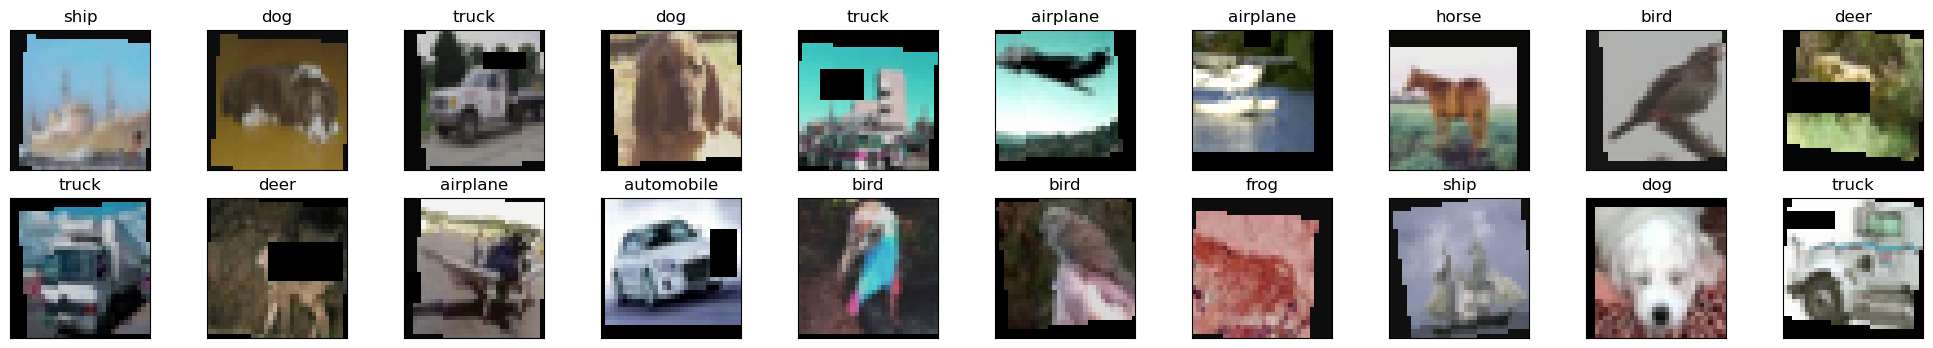

In [9]:
# 看一批训练图
dataiter = iter(train_loader)
images, labels = next(dataiter)
images_np = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in range(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  imshow(images_np[idx])
  ax.set_title(class_names[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

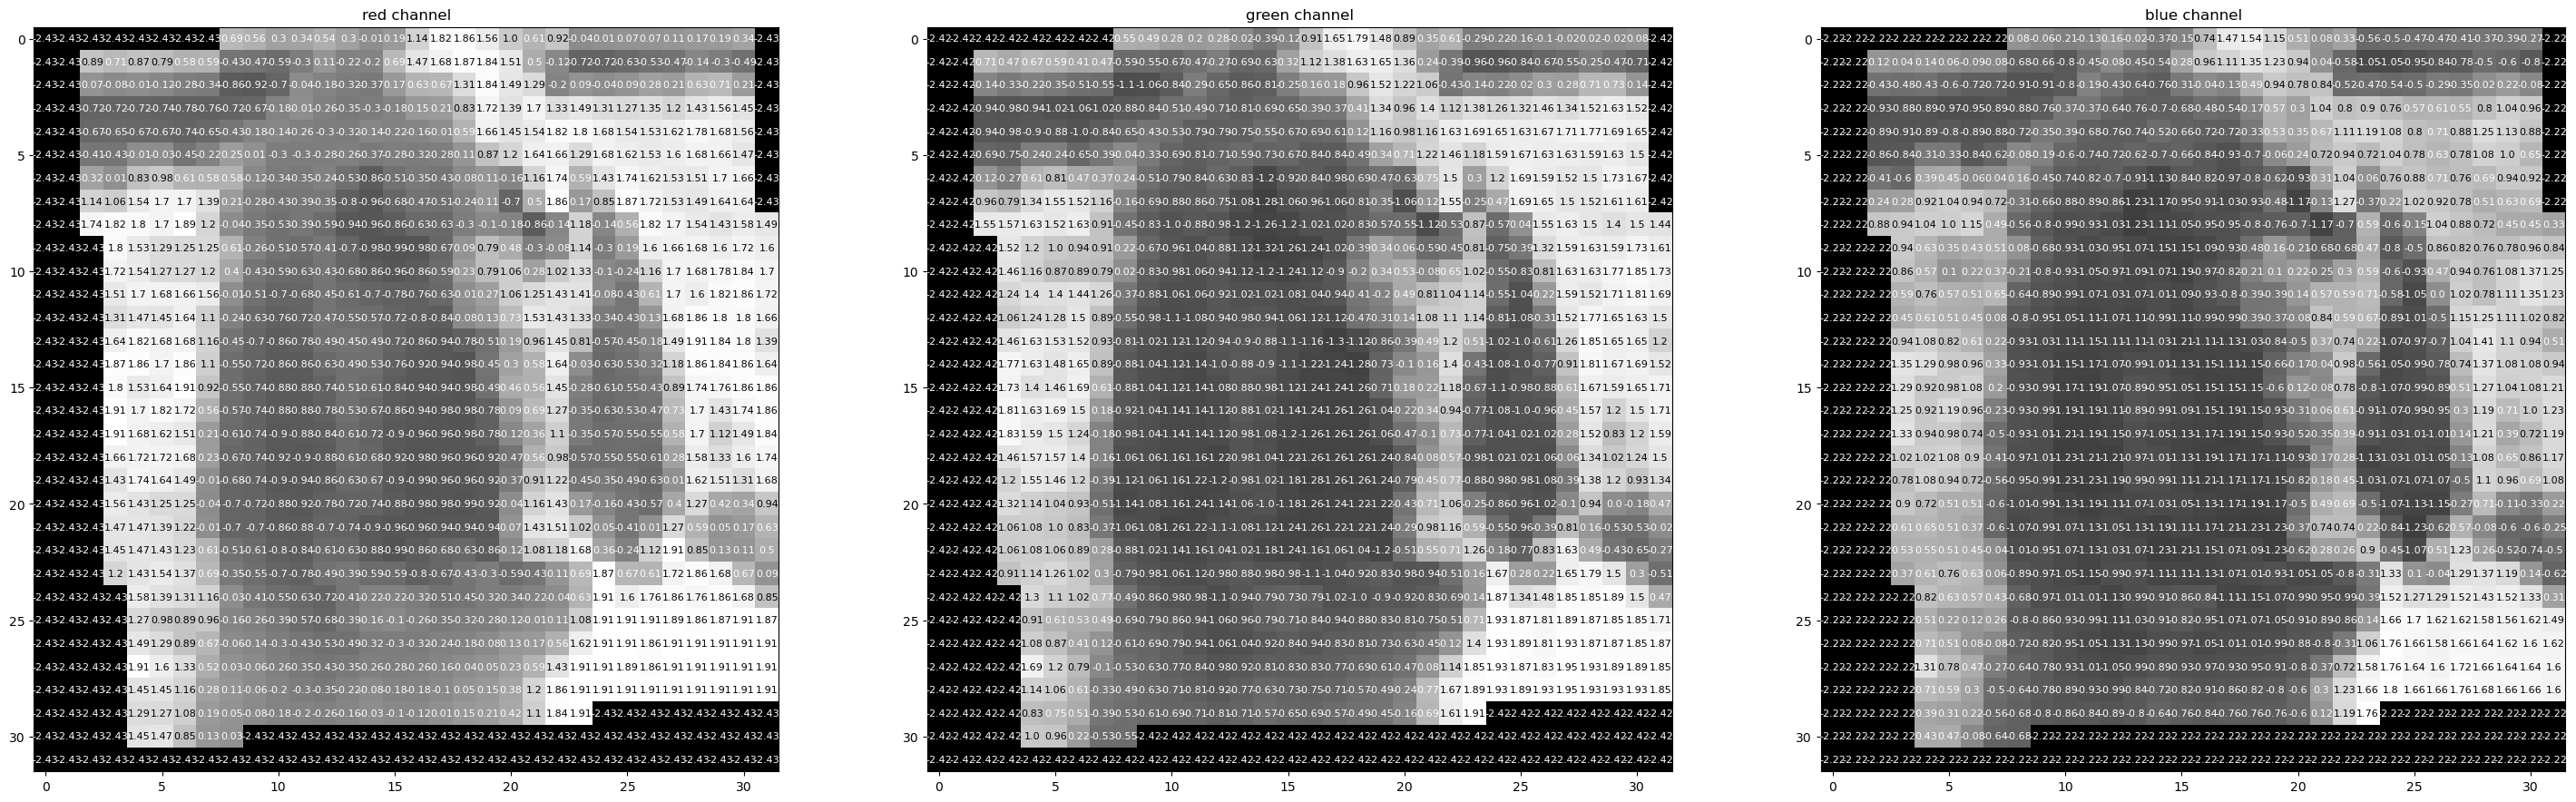

In [10]:
#每个通道画成一张 32×32 的灰度图，并在每个像素位置打上数值（归一化后的值）。
#这是帮你“感受” CNN 看到的输入是什么样子。
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize=(36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y].item(), 2) if img[x][y] != 0 else 0  # Convert tensor to float and round
            ax.annotate(str(val), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center', size=8,
                        color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.



<!-- <img src='notebook_ims/2_layer_conv.png' height=50% width=50% /> -->

#### TODO: Define a model with multiple convolutional layers, and define the feedforward network behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting. 

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

( (W−F+2P)/S)  +  1

In [11]:
#4. 模型结构：3x Conv + 3x Pool + 3x FC
#4.1 定义网络结构
# 我所做出的更改：保留你原来的小 CNN 作为 BaselineNet。
# 新增 ImprovedNet：更深一点，有 BatchNorm + Dropout。
# BaselineNet 就是你原来的网络，名字改一下而已。

# ImprovedNet 用 32→64→128 通道 + BatchNorm + Dropout，是一个典型的 CIFAR-10 小 CNN，会比 baseline 表达能力强很多。

# 现在默认实例化的是 BaselineNet，后面我们会专门再建一个 cell 重新实例化 ImprovedNet 训练第二轮。

In [12]:
# 4. 模型结构：BaselineNet + ImprovedNet
import torch.nn as nn
import torch.nn.functional as F

# --------------------
# Baseline CNN (用于 Problem 2)
# --------------------
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        # 3x32x32 -> 6x33x33 -> 6x16x16
        self.conv1 = nn.Conv2d(3, 6, 2, padding=1, stride=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        # 6x16x16 -> 16x17x17 -> 16x8x8
        self.conv2 = nn.Conv2d(6, 16, 2, padding=1, stride=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        # 16x8x8 -> 32x7x7 -> 32x3x3
        self.conv3 = nn.Conv2d(16, 32, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        # flatten 32*3*3 = 288
        self.fc1 = nn.Linear(32 * 3 * 3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# --------------------
# Improved CNN (用于 Problem 3)
#   - 使用更多通道、更深网络
#   - 每个卷积后接 BatchNorm
#   - 全连接层前加 Dropout
# --------------------
class ImprovedNet(nn.Module):
    def __init__(self):
        super(ImprovedNet, self).__init__()

        self.features = nn.Sequential(
            # Block 1: 3x32x32 -> 32x32x32 -> 32x32x32 -> 32x16x16
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, 2),  # 32x16x16

            # Block 2: 32x16x16 -> 64x16x16 -> 64x16x16 -> 64x8x8
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, 2),  # 64x8x8

            # Block 3: 64x8x8 -> 128x8x8 -> 128x8x8 -> 128x4x4
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.MaxPool2d(2, 2)   # 128x4x4
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)           # (N, 128, 4, 4)
        x = x.view(x.size(0), -1)      # (N, 128*4*4)
        x = self.classifier(x)         # (N, 10)
        return x


# --------------------
# Baseline 模型实例（先跑 baseline）
# --------------------
model = BaselineNet()
print("Baseline model:\n", model)

if train_on_gpu:
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs with DataParallel for BaselineNet!")
        model = nn.DataParallel(model)
    model = model.to(device)



Baseline model:
 BaselineNet(
  (conv1): Conv2d(3, 6, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=288, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Using 2 GPUs with DataParallel for BaselineNet!


In [13]:
#feature_calc 用来算尺寸的，你可以放到另一个小 cell 里（如果想保留），对核心训练没影响，也可以直接删掉。
def feature_calc(num_channels, k_size, stride , pad):
  calc_result=( ((num_channels - k_size + 2*pad ) / stride) + 1)
  return calc_result

In [14]:
a1=feature_calc(32, 2, 1, 1)
a2=feature_calc(np.floor(a1), 2, 2, 0)
a3=feature_calc(np.floor(a2), 2, 1, 1)
a4= feature_calc(np.floor(a3), 2, 2, 0)
a5= feature_calc(np.floor(a4), 2, 1, 0)
a6= feature_calc(np.floor(a5), 2, 2, 0)

print(a1, a2, a3, a4, a5, a6)

33.0 16.5 17.0 8.5 7.0 3.5


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

#### TODO: Define the loss and optimizer and see how these choices change the loss over time.

In [15]:
#这一段专门给 Baseline 用。
#ImprovedNet 我们会在后面单独开一个 cell 定义新 optimizer。
import torch.optim as optim

# --------------------
# Loss function
# --------------------
criterion = nn.CrossEntropyLoss()

# --------------------
# Optimizer for Baseline model
#   （和原始 notebook 一样，方便做公平对比）
# --------------------
# ==== Baseline: 跟老师一致的优化器 ====
optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)




---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [16]:
# --------------------
# Train the Baseline Network
# --------------------
n_epochs = 500 

valid_loss_min = np.inf

train_loss_history_baseline = []
valid_loss_history_baseline = []
train_acc_history_baseline = []
valid_acc_history_baseline = []

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    valid_loss = 0.0
    train_correct = 0
    train_total = 0
    valid_correct = 0
    valid_total = 0

    # -------- train --------
    model.train()
    for data, target in baseline_train_loader:   # ⭐ 用 baseline_train_loader
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)

        _, preds = torch.max(output, 1)
        train_correct += (preds == target).sum().item()
        train_total += target.size(0)

    # -------- validate --------
    model.eval()
    for data, target in baseline_valid_loader:   # ⭐ 用 baseline_valid_loader
        data, target = data.to(device), target.to(device)

        with torch.no_grad():
            output = model(data)
            loss = criterion(output, target)

        valid_loss += loss.item() * data.size(0)
        _, preds = torch.max(output, 1)
        valid_correct += (preds == target).sum().item()
        valid_total += target.size(0)

    train_loss = train_loss / len(baseline_train_loader.dataset)
    valid_loss = valid_loss / len(baseline_valid_loader.dataset)
    train_acc = train_correct / train_total
    valid_acc = valid_correct / valid_total

    train_loss_history_baseline.append(train_loss)
    valid_loss_history_baseline.append(valid_loss)
    train_acc_history_baseline.append(train_acc)
    valid_acc_history_baseline.append(valid_acc)

    print(f'Epoch: {epoch:2d} '
          f'Training Loss: {train_loss:.6f}  Validation Loss: {valid_loss:.6f}  '
          f'Train Acc: {train_acc:.4f}  Valid Acc: {valid_acc:.4f}')

    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
        model_to_save = model.module if isinstance(model, nn.DataParallel) else model
        torch.save(model_to_save.state_dict(), 'model_cifar_baseline.pt')
        valid_loss_min = valid_loss

print("Finished training BaselineNet.")


Epoch:  1 Training Loss: 1.842661  Validation Loss: 0.460623  Train Acc: 0.1008  Valid Acc: 0.0966
Validation loss decreased (inf --> 0.460623).  Saving model ...
Epoch:  2 Training Loss: 1.842153  Validation Loss: 0.460519  Train Acc: 0.1008  Valid Acc: 0.0966
Validation loss decreased (0.460623 --> 0.460519).  Saving model ...
Epoch:  3 Training Loss: 1.841766  Validation Loss: 0.460432  Train Acc: 0.1008  Valid Acc: 0.0966
Validation loss decreased (0.460519 --> 0.460432).  Saving model ...
Epoch:  4 Training Loss: 1.841439  Validation Loss: 0.460354  Train Acc: 0.1008  Valid Acc: 0.0966
Validation loss decreased (0.460432 --> 0.460354).  Saving model ...
Epoch:  5 Training Loss: 1.841128  Validation Loss: 0.460272  Train Acc: 0.1037  Valid Acc: 0.0979
Validation loss decreased (0.460354 --> 0.460272).  Saving model ...
Epoch:  6 Training Loss: 1.840795  Validation Loss: 0.460187  Train Acc: 0.1102  Valid Acc: 0.1049
Validation loss decreased (0.460272 --> 0.460187).  Saving model .

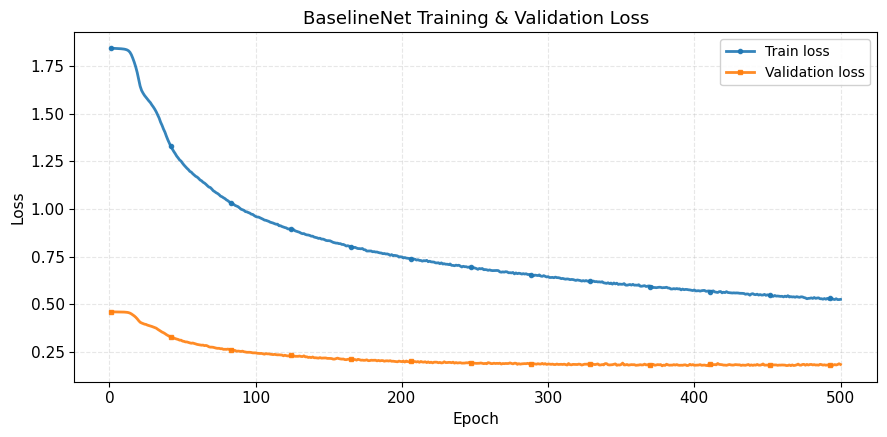

In [17]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, len(train_loss_history_baseline) + 1)

# 可选：统一一点字体大小
plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "legend.fontsize": 10
})

plt.figure(figsize=(9, 4.5))

plt.plot(
    epochs,
    train_loss_history_baseline,
    label='Train loss',
    linewidth=2.0,
    marker='o',
    markersize=3,
    markevery=max(len(epochs)//12, 1),  # 每隔几步加一个点，避免太密
    alpha=0.9
)

plt.plot(
    epochs,
    valid_loss_history_baseline,
    label='Validation loss',
    linewidth=2.0,
    marker='s',
    markersize=3,
    markevery=max(len(epochs)//12, 1),
    alpha=0.9
)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BaselineNet Training & Validation Loss')

# y 轴从 0 开始会更直观（如果你的 loss 很大可以酌情改）
plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
plt.legend(loc='best', frameon=True, framealpha=0.9)

plt.tight_layout()
plt.show()


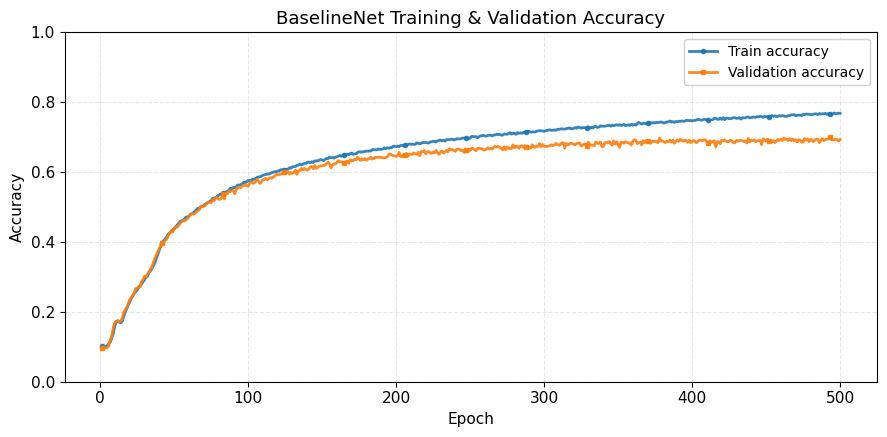

In [18]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, len(train_acc_history_baseline) + 1)

# 可选：统一一点字体风格（和前面的图一致）
plt.rcParams.update({
    "font.size": 11,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
    "legend.fontsize": 10
})

plt.figure(figsize=(9, 4.5))

plt.plot(
    epochs,
    train_acc_history_baseline,
    label='Train accuracy',
    linewidth=2.0,
    marker='o',
    markersize=3,
    markevery=max(len(epochs)//12, 1),  # 每隔几个 epoch 标一个点
    alpha=0.9
)

plt.plot(
    epochs,
    valid_acc_history_baseline,
    label='Validation accuracy',
    linewidth=2.0,
    marker='s',
    markersize=3,
    markevery=max(len(epochs)//12, 1),
    alpha=0.9
)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('BaselineNet Training & Validation Accuracy')
plt.ylim(0.0, 1.0)  # 准确率一般是 0~1，更好读

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
plt.legend(loc='best', frameon=True, framealpha=0.9)

plt.tight_layout()
plt.show()


In [19]:
#新增 Cell：训练 ImprovedNet（Problem 3 用）
# 现在我们要：
# 重新实例化模型为 ImprovedNet；
# 定义新的 optimizer（比如 Adam + weight decay）；
# 用类似的训练 loop，保存到 model_cifar_improved.pt。

In [20]:
# 实例化 ImprovedNet + 新 optimizer

In [21]:
# --------------------
# 重新实例化 ImprovedNet 模型
# --------------------
# 定义一个初始化函数（可以放在 ImprovedNet 定义下面）
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(m.bias)

# --------------------
# 重新实例化 ImprovedNet 模型
# --------------------
model_improved = ImprovedNet()
model_improved.apply(init_weights)   # ✅ 在这里应用初始化
print("Improved model:\n", model_improved)

if train_on_gpu:
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs with DataParallel for ImprovedNet!")
        model_improved = nn.DataParallel(model_improved)
    model_improved = model_improved.to(device)



# 仍然使用 CrossEntropyLoss
criterion_improved = nn.CrossEntropyLoss()

# 使用 Adam + weight decay，收敛更快，一般在 CIFAR-10 上表现更好
optimizer_improved = optim.Adam(model_improved.parameters(),
                                lr=1e-3, weight_decay=5e-4)

# 可选：学习率 scheduler（每 15 个 epoch 衰减一次）
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler_improved = CosineAnnealingLR(
    optimizer_improved,
    T_max=500,   # 与 epoch 数一致
    eta_min=1e-6 # 最低学习率
)




Improved model:
 ImprovedNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (

In [22]:
#训练 ImprovedNet

In [23]:
n_epochs_improved = 500   # 最终实验建议 >=30，这里先写 30
valid_loss_min_improved = np.inf

train_loss_history_improved = []
valid_loss_history_improved = []
train_acc_history_improved = []
valid_acc_history_improved = []

for epoch in range(1, n_epochs_improved+1):

    train_loss = 0.0
    valid_loss = 0.0
    train_correct = 0
    train_total = 0
    valid_correct = 0
    valid_total = 0

    # -------- train --------
    model_improved.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer_improved.zero_grad()
        output = model_improved(data)
        loss = criterion_improved(output, target)
        loss.backward()
        optimizer_improved.step()

        train_loss += loss.item() * data.size(0)

        # 统计训练集准确率
        _, preds = torch.max(output, 1)
        train_correct += (preds == target).sum().item()
        train_total += target.size(0)

    # -------- validate --------
    model_improved.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)

        with torch.no_grad():
            output = model_improved(data)
            loss = criterion_improved(output, target)

        valid_loss += loss.item() * data.size(0)

        # 统计验证集准确率
        _, preds = torch.max(output, 1)
        valid_correct += (preds == target).sum().item()
        valid_total += target.size(0)

    train_loss = train_loss / train_total
    valid_loss = valid_loss / valid_total
    train_acc = train_correct / train_total
    valid_acc = valid_correct / valid_total

    train_loss_history_improved.append(train_loss)
    valid_loss_history_improved.append(valid_loss)
    train_acc_history_improved.append(train_acc)
    valid_acc_history_improved.append(valid_acc)

    print(f'[Improved] Epoch: {epoch:2d} '
          f'Train Loss: {train_loss:.6f}  Val Loss: {valid_loss:.6f}  '
          f'Train Acc: {train_acc:.4f}  Val Acc: {valid_acc:.4f}')

    if valid_loss <= valid_loss_min_improved:
        print(f'Validation loss decreased ({valid_loss_min_improved:.6f} --> {valid_loss:.6f}).  Saving improved model ...')
        model_to_save = model_improved.module if isinstance(model_improved, nn.DataParallel) else model_improved
        torch.save(model_to_save.state_dict(), 'model_cifar_improved.pt')
        valid_loss_min_improved = valid_loss

    scheduler_improved.step()

print("Finished training ImprovedNet.")


[Improved] Epoch:  1 Train Loss: 2.059966  Val Loss: 1.606659  Train Acc: 0.2352  Val Acc: 0.3967
Validation loss decreased (inf --> 1.606659).  Saving improved model ...
[Improved] Epoch:  2 Train Loss: 1.748388  Val Loss: 1.497850  Train Acc: 0.3430  Val Acc: 0.4371
Validation loss decreased (1.606659 --> 1.497850).  Saving improved model ...
[Improved] Epoch:  3 Train Loss: 1.594277  Val Loss: 1.285322  Train Acc: 0.4062  Val Acc: 0.5207
Validation loss decreased (1.497850 --> 1.285322).  Saving improved model ...
[Improved] Epoch:  4 Train Loss: 1.452529  Val Loss: 1.146616  Train Acc: 0.4729  Val Acc: 0.5761
Validation loss decreased (1.285322 --> 1.146616).  Saving improved model ...
[Improved] Epoch:  5 Train Loss: 1.344992  Val Loss: 1.057963  Train Acc: 0.5179  Val Acc: 0.6129
Validation loss decreased (1.146616 --> 1.057963).  Saving improved model ...
[Improved] Epoch:  6 Train Loss: 1.254221  Val Loss: 0.952986  Train Acc: 0.5540  Val Acc: 0.6503
Validation loss decreased (

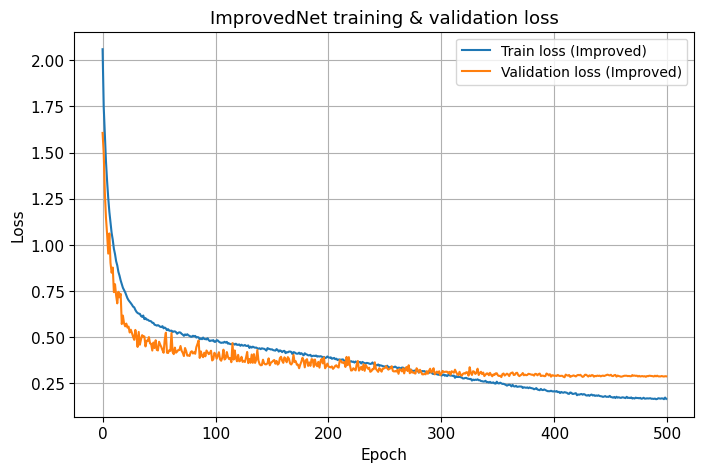

In [24]:
# 再加一个小 cell 画 ImprovedNet 的 loss 曲线：
plt.figure(figsize=(8, 5))
plt.plot(train_loss_history_improved, label='Train loss (Improved)')
plt.plot(valid_loss_history_improved, label='Validation loss (Improved)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('ImprovedNet training & validation loss')
plt.legend()
plt.grid(True)
plt.show()

###  Load the Model with the Lowest Validation Loss

In [25]:
# model.load_state_dict(torch.load('model_cifar.pt'))

In [26]:
# Load model（改为分别加载 baseline / improved）
# --------------------
# 加载 baseline 模型（用于后面 baseline 测试）
# --------------------
baseline_model = BaselineNet()
baseline_model.load_state_dict(torch.load('model_cifar_baseline.pt'))
if train_on_gpu:
    baseline_model.cuda()
baseline_model.eval()

# --------------------
# 加载 improved 模型（用于后面 improved 测试）
# --------------------
improved_model = ImprovedNet()
improved_model.load_state_dict(torch.load('model_cifar_improved.pt'))
if train_on_gpu:
    improved_model.cuda()
improved_model.eval()

/tmp/ipykernel_39264/3646600778.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  baseline_model.load_state_dict(torch.load('model_cifar_baseline.pt'))
/tmp/ipykernel_3926

ImprovedNet(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 1

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [27]:
# # track test loss
# test_loss = 0.0
# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))

# model.eval()
# # iterate over test data
# for data, target in test_loader:
#     # move tensors to GPU if CUDA is available
#     if train_on_gpu:
#         data, target = data.cuda(), target.cuda()
#     # forward pass: compute predicted outputs by passing inputs to the model
#     output = model(data)
#     # calculate the batch loss
#     loss = criterion(output, target)
#     # update test loss 
#     test_loss += loss.item()*data.size(0)
#     # convert output probabilities to predicted class
#     _, pred = torch.max(output, 1)    
#     # compare predictions to true label
#     correct_tensor = pred.eq(target.data.view_as(pred))
#     correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
#     # calculate test accuracy for each object class
#     for i in range(batch_size):
#         label = target.data[i]
#         class_correct[label] += correct[i].item()
#         class_total[label] += 1

# # average test loss
# test_loss = test_loss/len(test_loader.dataset)
# print('Test Loss: {:.6f}\n'.format(test_loss))

# for i in range(10):
#     if class_total[i] > 0:
#         print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
#             class_names[i], 100 * class_correct[i] / class_total[i],
#             np.sum(class_correct[i]), np.sum(class_total[i])))
#     else:
#         print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
#     100. * np.sum(class_correct) / np.sum(class_total),
#     np.sum(class_correct), np.sum(class_total)))

In [28]:
# Test the Trained Network（拆成两个：Baseline 和 Improved）
# 把原来的测试 cell 分成两个子块：先 baseline，再 improved。
# 结构几乎一样，只是用的模型不同、保存结果的变量不同。

正在收集 Baseline 模型数据...
正在收集 Improved 模型数据...


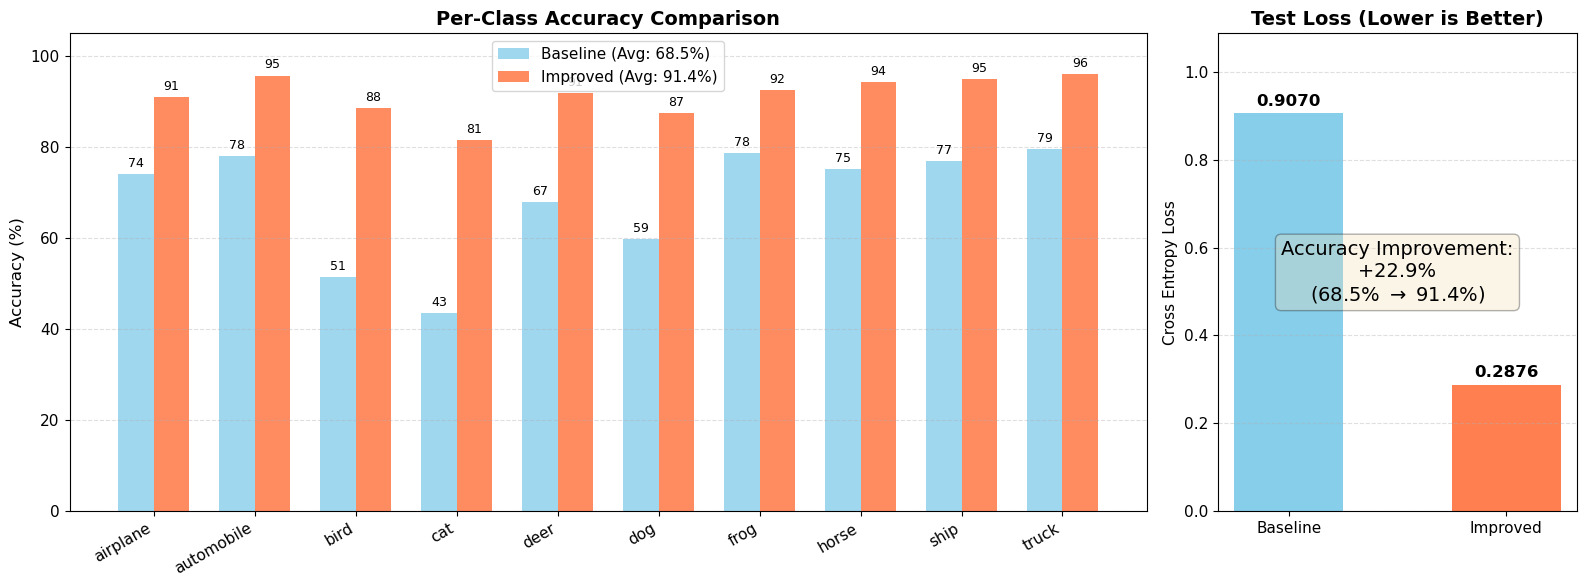

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# 假设环境里已经定义了 device, test_loader, baseline_model, improved_model, criterion, criterion_improved, class_names

# ==========================================
# 1. 封装测试函数以收集数据
# ==========================================
def get_test_results(model, loader, criterion, device):
    test_loss = 0.0
    class_correct = list(0. for _ in range(10))
    class_total = list(0. for _ in range(10))
    
    model.eval()
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            
            test_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, 1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # 兼容处理
            correct = correct_tensor.cpu().numpy()
            
            for i in range(len(target)):
                label = target.data[i].item()
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    # 计算最终指标
    avg_loss = test_loss / len(loader.dataset)
    per_class_acc = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(10)]
    overall_acc = 100. * sum(class_correct) / sum(class_total)
    
    return avg_loss, overall_acc, per_class_acc

print("正在收集 Baseline 模型数据...")
base_loss, base_acc, base_class_acc = get_test_results(
    baseline_model, baseline_test_loader, criterion, device
)

print("正在收集 Improved 模型数据...")
imp_loss, imp_acc, imp_class_acc = get_test_results(
    improved_model, test_loader, criterion_improved, device
)


# ==========================================
# 2. 绘制对比图
# ==========================================
# 设置画布：宽一些，以便容纳两个子图
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [3, 1]})

# --- 子图 1: 各类别准确率对比 (Grouped Bar Chart) ---
x = np.arange(len(class_names))
width = 0.35  # 柱子的宽度

rects1 = ax1.bar(x - width/2, base_class_acc, width, label=f'Baseline (Avg: {base_acc:.1f}%)', color='skyblue', alpha=0.8)
rects2 = ax1.bar(x + width/2, imp_class_acc, width, label=f'Improved (Avg: {imp_acc:.1f}%)', color='coral', alpha=0.9)

ax1.set_ylabel('Accuracy (%)', fontsize=12)
ax1.set_title('Per-Class Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(class_names, rotation=30, ha='right', fontsize=11)
ax1.set_ylim(0, 105) # 稍微高一点留出写字空间
ax1.legend(fontsize=11)
ax1.grid(axis='y', linestyle='--', alpha=0.4)

# 在柱子上标注数值
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 垂直偏移
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

autolabel(rects1, ax1)
autolabel(rects2, ax1)

# --- 子图 2: 整体指标对比 (Loss & Overall Acc) ---
# 这里我们用两个小的子柱状图或者文本显示
metrics = ['Test Loss', 'Overall Accuracy (%)']
x_metrics = np.arange(len(metrics))

# 数据准备：Loss 和 Accuracy 量纲不同，这里我们用双轴或者分开画，
# 为了简洁，我们画 Loss 的对比柱状图，并在标题直接写出 Accuracy 提升
# 或者是归一化显示。这里选择画 Loss 对比，因为 Acc 已经在左图 Legend 里体现了。

# 重新设计 ax2：只画 Loss 对比，Acc 用大字写
loss_values = [base_loss, imp_loss]
bar_colors = ['skyblue', 'coral']

bars = ax2.bar(['Baseline', 'Improved'], loss_values, color=bar_colors, width=0.5)
ax2.set_title('Test Loss (Lower is Better)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cross Entropy Loss')
ax2.set_ylim(0, max(loss_values) * 1.2)
ax2.grid(axis='y', linestyle='--', alpha=0.4)

# 在 Loss 柱子上标数值
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# 在图中间添加 Overall Accuracy 的文字提升说明
acc_improvement = imp_acc - base_acc
text_str = (f"Accuracy Improvement:\n"
            f"+{acc_improvement:.1f}%\n"
            f"({base_acc:.1f}% $\\rightarrow$ {imp_acc:.1f}%)")

# 在图的空白处添加文本框
props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
ax2.text(0.5, 0.5, text_str, transform=ax2.transAxes, fontsize=14,
        verticalalignment='center', horizontalalignment='center', bbox=props)

plt.tight_layout()
plt.show()

In [37]:
# 新增 Cell：Confusion Matrix（评价指标更丰富）
import torch
import torch.nn.functional as F

# --------------------
# 收集整个测试集的预测结果（使用 improved_model）
# --------------------
model_eval = improved_model   # 或 baseline_model
model_eval.eval()

all_images = []
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model_eval(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)

        all_images.append(images.cpu())
        all_labels.append(labels)
        all_preds.append(preds.cpu())
        all_probs.append(probs.cpu())

all_images = torch.cat(all_images, dim=0)   # [N,3,32,32]
all_labels = torch.cat(all_labels, dim=0)   # [N]
all_preds = torch.cat(all_preds, dim=0)     # [N]
all_probs = torch.cat(all_probs, dim=0)     # [N,10]

print("Collected {} test examples.".format(all_labels.size(0)))

Collected 10000 test examples.


In [38]:
num_classes = 10

# 统计 per-class 正确数 / 总数
class_correct = [0] * num_classes
class_total = [0] * num_classes

for label, pred in zip(all_labels, all_preds):
    class_total[label.item()] += 1
    if label == pred:
        class_correct[label.item()] += 1

class_acc = [c / t if t > 0 else 0.0 for c, t in zip(class_correct, class_total)]
overall_acc = sum(class_correct) / sum(class_total)
print(f"Overall Test Accuracy: {overall_acc*100:.2f}%")

# -------- Confusion matrix (建议整合在这里) --------
conf_mat = torch.zeros(num_classes, num_classes, dtype=torch.int64)
for t, p in zip(all_labels, all_preds):
    conf_mat[t.long(), p.long()] += 1

Overall Test Accuracy: 91.41%


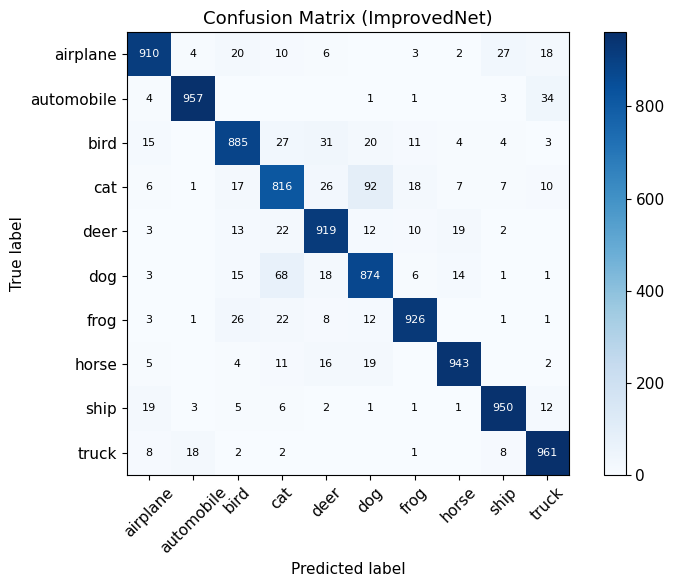

In [39]:
# 简单画个热力图

plt.figure(figsize=(8, 6))
plt.imshow(conf_mat.numpy(), interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix (ImprovedNet)')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# ⭐ 在每个小方块里标数字
mat = conf_mat.numpy()
thresh = mat.max() / 2.0  # 用来决定文字颜色（深色背景上用白字）

for i in range(num_classes):        # 行：真实类别
    for j in range(num_classes):    # 列：预测类别
        value = mat[i, j]
        if value > 0:  # 0 的格子可写可不写，看你喜好
            plt.text(
                j, i,                      # (x=j, y=i) 对应第 i 行第 j 列
                str(value),               # 显示次数
                ha='center', va='center',
                color='white' if value > thresh else 'black',
                fontsize=8
            )

plt.tight_layout()
plt.show()

In [40]:
# Visualize Sample Test Results（加上置信度显示）

### Question: What are your model's weaknesses and how might they be improved?

**Answer**: (double-click to edit and add an answer)

### Visualize Sample Test Results

In [47]:
# --------------------
# 找出置信度最高的正确样本 & 错误样本
# --------------------

conf_all = []

for idx, (label, pred, prob_vec) in enumerate(zip(all_labels, all_preds, all_probs)):
    pred_idx = pred.item()
    conf = prob_vec[pred_idx].item()
    conf_all.append((idx, label.item(), pred_idx, conf))

# 按置信度排序
conf_all_sorted = sorted(conf_all, key=lambda x: x[3], reverse=True)

# 取高置信度正确 & 错误各若干个
top_k = 20  # 每类取 20 个
best_correct = []
worst_wrong = []

for idx, label, pred_idx, conf in conf_all_sorted:
    if label == pred_idx and len(best_correct) < top_k:
        best_correct.append((idx, label, pred_idx, conf))
    elif label != pred_idx and len(worst_wrong) < top_k:
        worst_wrong.append((idx, label, pred_idx, conf))
    if len(best_correct) >= top_k and len(worst_wrong) >= top_k:
        break

print(f"Collected {len(best_correct)} very confident correct examples.")
print(f"Collected {len(worst_wrong)} very confident but wrong examples.")


Collected 20 very confident correct examples.
Collected 20 very confident but wrong examples.


In [48]:
import torch
import torch.nn.functional as F

model_eval = improved_model   # 或者 baseline_model
model_eval.eval()

correct_confidences = []
wrong_confidences = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_eval(images)
        probs = F.softmax(outputs, dim=1)   # [batch, 10]

        # 每个样本预测类别以及该类别的置信度
        confs, preds = probs.max(dim=1)     # confs: [batch], preds: [batch]

        correct_mask = preds.eq(labels)     # [batch] True/False

        # 按照“预测对 / 预测错”把置信度分成两堆
        correct_confidences.extend(confs[correct_mask].cpu().numpy().tolist())
        wrong_confidences.extend(confs[~correct_mask].cpu().numpy().tolist())

print(f"#correct = {len(correct_confidences)}, #wrong = {len(wrong_confidences)}")


#correct = 9141, #wrong = 859


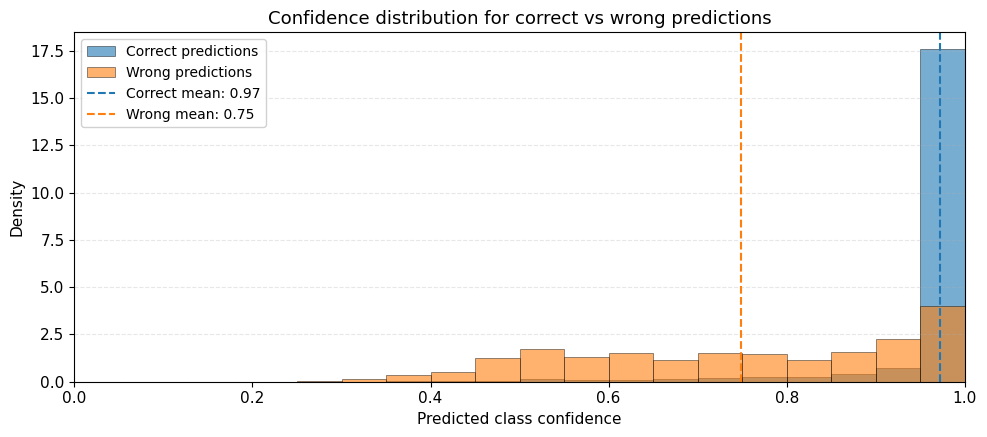

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# 转成 numpy，后面更好处理
correct_confidences = np.array(correct_confidences)
wrong_confidences = np.array(wrong_confidences)

# 统一的 bins：0~1 划分成 20 段
bins = np.linspace(0.0, 1.0, 21)

plt.figure(figsize=(10, 4.5))

# 正确预测的置信度分布
plt.hist(
    correct_confidences,
    bins=bins,
    alpha=0.6,
    density=True,              # 画成密度分布，看形状更直观
    label="Correct predictions",
    edgecolor="black",
    linewidth=0.5
)

# 错误预测的置信度分布
plt.hist(
    wrong_confidences,
    bins=bins,
    alpha=0.6,
    density=True,
    label="Wrong predictions",
    edgecolor="black",
    linewidth=0.5
)

# 计算均值
correct_mean = correct_confidences.mean() if len(correct_confidences) > 0 else 0.0
wrong_mean = wrong_confidences.mean() if len(wrong_confidences) > 0 else 0.0

# 均值竖线
plt.axvline(
    correct_mean,
    linestyle="--",
    linewidth=1.5,
    color="tab:blue",
    label=f"Correct mean: {correct_mean:.2f}"
)
plt.axvline(
    wrong_mean,
    linestyle="--",
    linewidth=1.5,
    color="tab:orange",
    label=f"Wrong mean: {wrong_mean:.2f}"
)

plt.xlim(0.0, 1.0)
plt.xlabel("Predicted class confidence")
plt.ylabel("Density")
plt.title("Confidence distribution for correct vs wrong predictions")

plt.grid(True, axis="y", alpha=0.3, linestyle="--", linewidth=0.8)
plt.legend(frameon=True, framealpha=0.9)
plt.tight_layout()
plt.show()


In [50]:
# --------------------
# 找出置信度最高的正确样本 & 错误样本
# --------------------
conf_all = []

for idx, (label, pred, prob_vec) in enumerate(zip(all_labels, all_preds, all_probs)):
    pred_idx = pred.item()
    conf = prob_vec[pred_idx].item()
    conf_all.append((idx, label.item(), pred_idx, conf))

# 按置信度排序
conf_all_sorted = sorted(conf_all, key=lambda x: x[3], reverse=True)

# 取高置信度正确 & 错误各若干个
top_k = 20  # 每类取 20 个
best_correct = []
worst_wrong = []

for idx, label, pred_idx, conf in conf_all_sorted:
    if label == pred_idx and len(best_correct) < top_k:
        best_correct.append((idx, label, pred_idx, conf))
    elif label != pred_idx and len(worst_wrong) < top_k:
        worst_wrong.append((idx, label, pred_idx, conf))
    if len(best_correct) >= top_k and len(worst_wrong) >= top_k:
        break

print(f"Collected {len(best_correct)} very confident correct examples.")
print(f"Collected {len(worst_wrong)} very confident but wrong examples.")


Collected 20 very confident correct examples.
Collected 20 very confident but wrong examples.


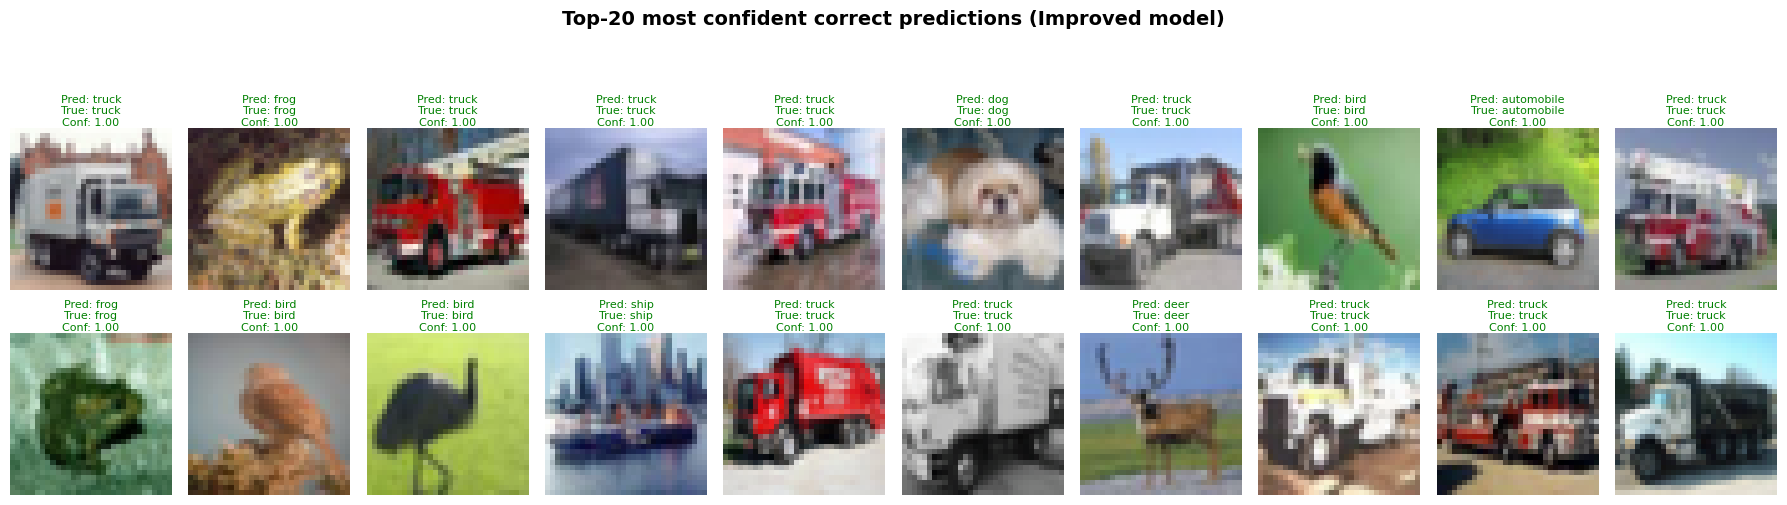

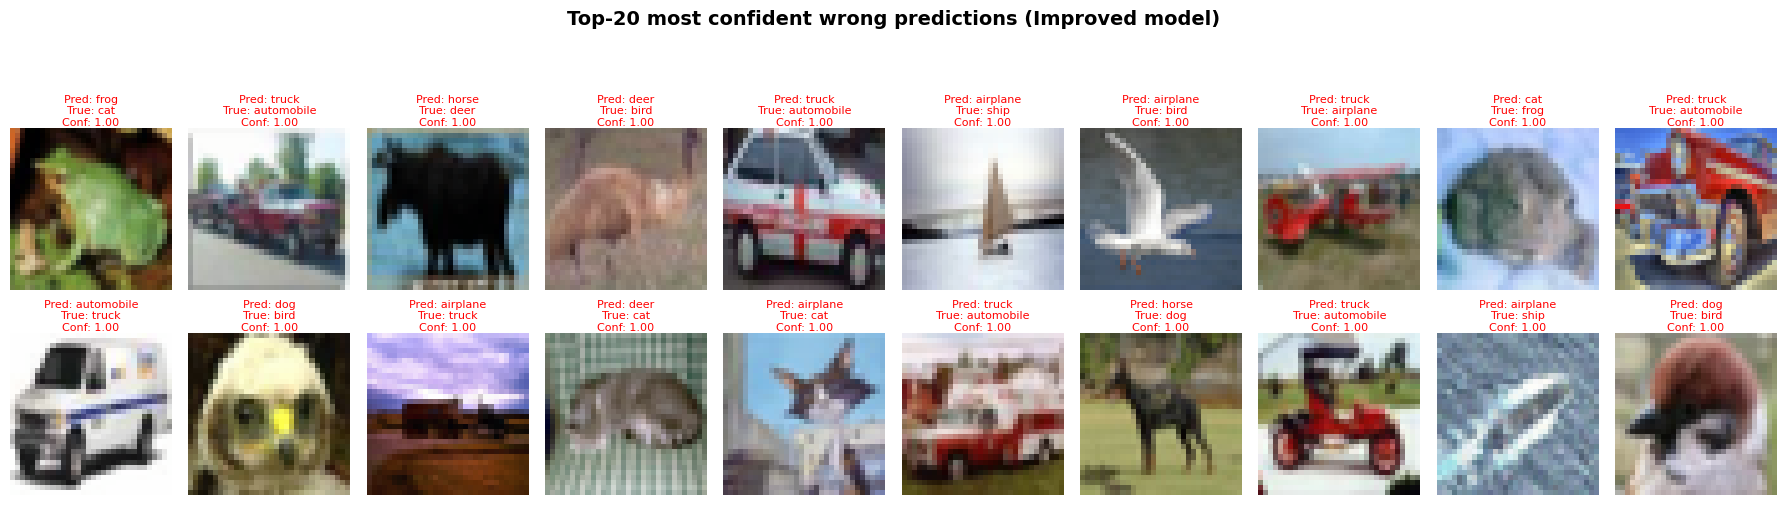

In [51]:
from xxlimited import new
import matplotlib.pyplot as plt
import numpy as np

def newimshow(img, ax=None):
    """
    img: tensor [C,H,W] 或 numpy [C,H,W]
    ax: 要画到哪一个 subplot 上，如果为 None 就画到当前轴
    """
    if torch.is_tensor(img):
        img = img.cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # [H,W,C]

    # 反归一化：x = x*std + mean
    img = img * np.array(cifar_std) + np.array(cifar_mean)
    img = np.clip(img, 0, 1)

    if ax is None:
        ax = plt.gca()
    ax.imshow(img)
    ax.axis("off")


import matplotlib.pyplot as plt
import numpy as np

def plot_examples(example_list, title, cols=10):
    """
    example_list: [(idx, label, pred_idx, conf), ...]
    title: 整体标题
    cols: 每行最多显示多少张图
    """
    num = len(example_list)
    if num == 0:
        print("No examples to plot.")
        return

    cols = min(cols, num)
    rows = int(np.ceil(num / cols))

    # 每张图大概 1.8 x 2 inch
    # ✅ 每行整体变高一点（2.8 比 2.0 高）
    fig, axes = plt.subplots(rows, cols,
                             figsize=(1.8 * cols, 2.6 * rows))

    # 兼容 rows=1 或 cols=1 的情况
    axes = np.array(axes).reshape(-1)

    # 先把所有子图轴都关掉
    for ax in axes:
        ax.axis('off')

    # 逐个填图
    for ax, (idx, label, pred_idx, conf) in zip(axes, example_list):
        # 画图：注意这里传 ax
        newimshow(all_images[idx], ax=ax)

        pred_label = class_names[pred_idx]
        true_label = class_names[label]

        title_text = f"Pred: {pred_label}\nTrue: {true_label}\nConf: {conf:.2f}"
        color = "green" if pred_idx == label else "red"

        ax.set_title(title_text,
                     color=color,
                     fontsize=8,
                     pad=2)

    # 整体大标题
    fig.suptitle(title,
                 fontsize=14,
                 fontweight='bold',
                 y=1.02)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
plot_examples(best_correct, "Top-20 most confident correct predictions (Improved model)")
plot_examples(worst_wrong, "Top-20 most confident wrong predictions (Improved model)")

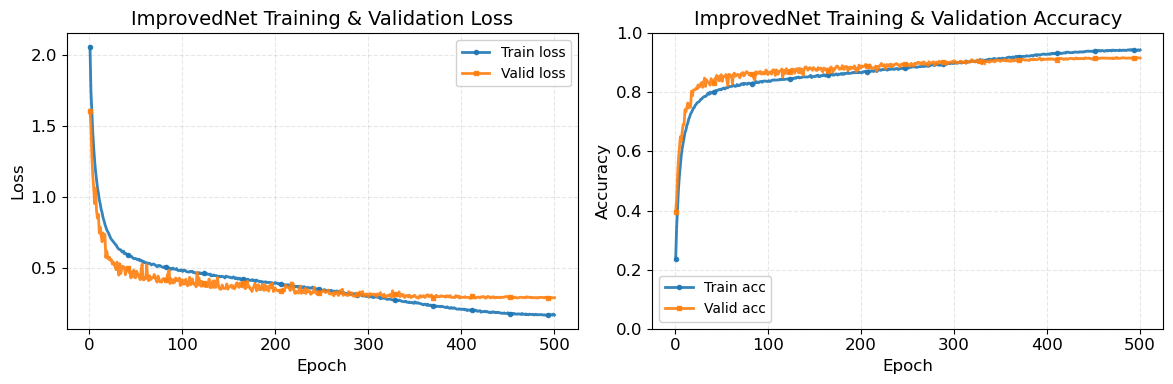

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# 假设这些 list 已经有了：
# train_loss_history_improved, valid_loss_history_improved
# train_acc_history_improved, valid_acc_history_improved

epochs = np.arange(1, len(train_loss_history_improved) + 1)

# 整体风格稍微调一下（可选）
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 10
})

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# --------------------
# 左图：Loss 曲线
# --------------------
ax = axes[0]
ax.plot(epochs, train_loss_history_improved,
        label='Train loss',
        linewidth=2.0,
        marker='o',
        markersize=3,
        markevery=max(len(epochs)//12, 1),
        alpha=0.9)

ax.plot(epochs, valid_loss_history_improved,
        label='Valid loss',
        linewidth=2.0,
        marker='s',
        markersize=3,
        markevery=max(len(epochs)//12, 1),
        alpha=0.9)

ax.set_title('ImprovedNet Training & Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(loc='best', frameon=True, framealpha=0.9)

# --------------------
# 右图：Accuracy 曲线
# --------------------
ax = axes[1]
ax.plot(epochs, train_acc_history_improved,
        label='Train acc',
        linewidth=2.0,
        marker='o',
        markersize=3,
        markevery=max(len(epochs)//12, 1),
        alpha=0.9)

ax.plot(epochs, valid_acc_history_improved,
        label='Valid acc',
        linewidth=2.0,
        marker='s',
        markersize=3,
        markevery=max(len(epochs)//12, 1),
        alpha=0.9)

ax.set_title('ImprovedNet Training & Validation Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.set_ylim(0, 1.0)  # 准确率一般在 0~1 之间，看起来更直观
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.legend(loc='best', frameon=True, framealpha=0.9)

# --------------------
# 总体布局 & 显示
# --------------------
plt.tight_layout()
plt.show()


Confusion matrix:
 tensor([[910,   4,  20,  10,   6,   0,   3,   2,  27,  18],
        [  4, 957,   0,   0,   0,   1,   1,   0,   3,  34],
        [ 15,   0, 885,  27,  31,  20,  11,   4,   4,   3],
        [  6,   1,  17, 816,  26,  92,  18,   7,   7,  10],
        [  3,   0,  13,  22, 919,  12,  10,  19,   2,   0],
        [  3,   0,  15,  68,  18, 874,   6,  14,   1,   1],
        [  3,   1,  26,  22,   8,  12, 926,   0,   1,   1],
        [  5,   0,   4,  11,  16,  19,   0, 943,   0,   2],
        [ 19,   3,   5,   6,   2,   1,   1,   1, 950,  12],
        [  8,  18,   2,   2,   0,   0,   1,   0,   8, 961]])


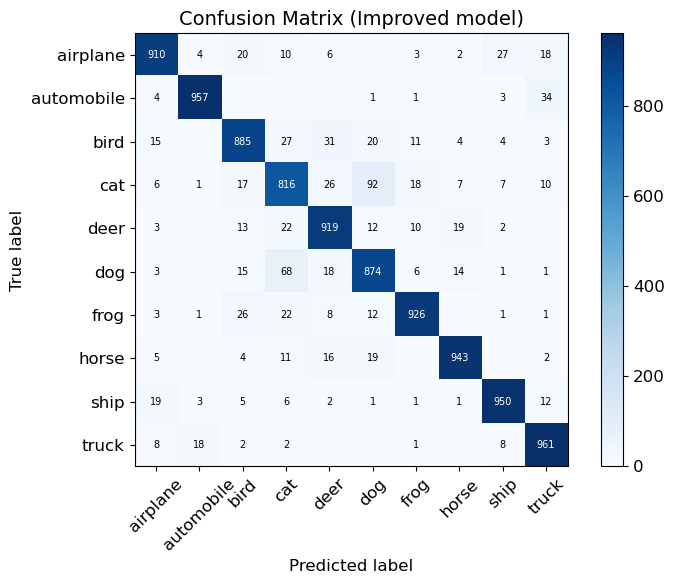

In [53]:
# --------------------
# Confusion matrix (rows = true classes, cols = predicted)
# --------------------
conf_mat = torch.zeros(num_classes, num_classes, dtype=torch.int64)

for t, p in zip(all_labels, all_preds):
    conf_mat[t.long(), p.long()] += 1

print("Confusion matrix:\n", conf_mat)

plt.figure(figsize=(8, 6))
plt.imshow(conf_mat.numpy(), interpolation='nearest', cmap='Blues')
plt.title('Confusion Matrix (Improved model)')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# 在格子里写数字（可选）
thresh = conf_mat.max().item() / 2.
for i in range(num_classes):
    for j in range(num_classes):
        num = conf_mat[i, j].item()
        if num > 0:
            plt.text(j, i, str(num),
                     ha="center", va="center",
                     color="white" if num > thresh else "black",
                     fontsize=7)

plt.tight_layout()
plt.show()


Overall Test Accuracy: 91.41%


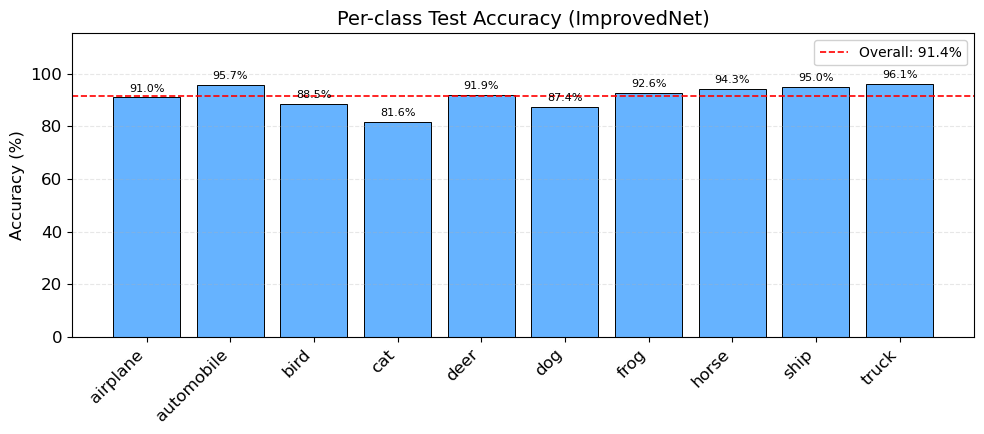

In [54]:
num_classes = 10

# 统计 per-class 正确数 / 总数
class_correct = [0] * num_classes
class_total = [0] * num_classes

for label, pred in zip(all_labels, all_preds):
    class_total[label.item()] += 1
    if label == pred:
        class_correct[label.item()] += 1

class_acc = [c / t if t > 0 else 0.0 for c, t in zip(class_correct, class_total)]
overall_acc = sum(class_correct) / sum(class_total)
print(f"Overall Test Accuracy: {overall_acc*100:.2f}%")

# -------- 美化后的柱状图 --------
acc_percent = np.array(class_acc) * 100
x = np.arange(num_classes)

plt.figure(figsize=(10, 4.5))

# 画柱子：稍微浅一点的颜色 + 黑色边框
bars = plt.bar(
    x,
    acc_percent,
    color="#66b3ff",          # 淡蓝
    edgecolor="black",
    linewidth=0.7
)

# 加 overall accuracy 参考线
plt.axhline(
    overall_acc * 100,
    color="red",
    linestyle="--",
    linewidth=1.2,
    label=f"Overall: {overall_acc*100:.1f}%"
)

# x 轴类名
plt.xticks(x, class_names, rotation=45, ha="right")

plt.ylabel("Accuracy (%)")
plt.title("Per-class Test Accuracy (ImprovedNet)")

# y 轴范围留一点空白方便写数字
max_y = max(acc_percent.max(), overall_acc*100)
plt.ylim(0, max_y * 1.2)

# y 轴加浅网格线
plt.grid(axis="y", alpha=0.3, linestyle="--", linewidth=0.8)

# 每个柱子上写准确率数值
for bar, acc in zip(bars, acc_percent):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + max_y * 0.015,   # 比原来 acc*100+1 更自适应一点
        f"{acc:.1f}%",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.legend(loc="upper right", frameon=True, framealpha=0.9)
plt.tight_layout()
plt.show()


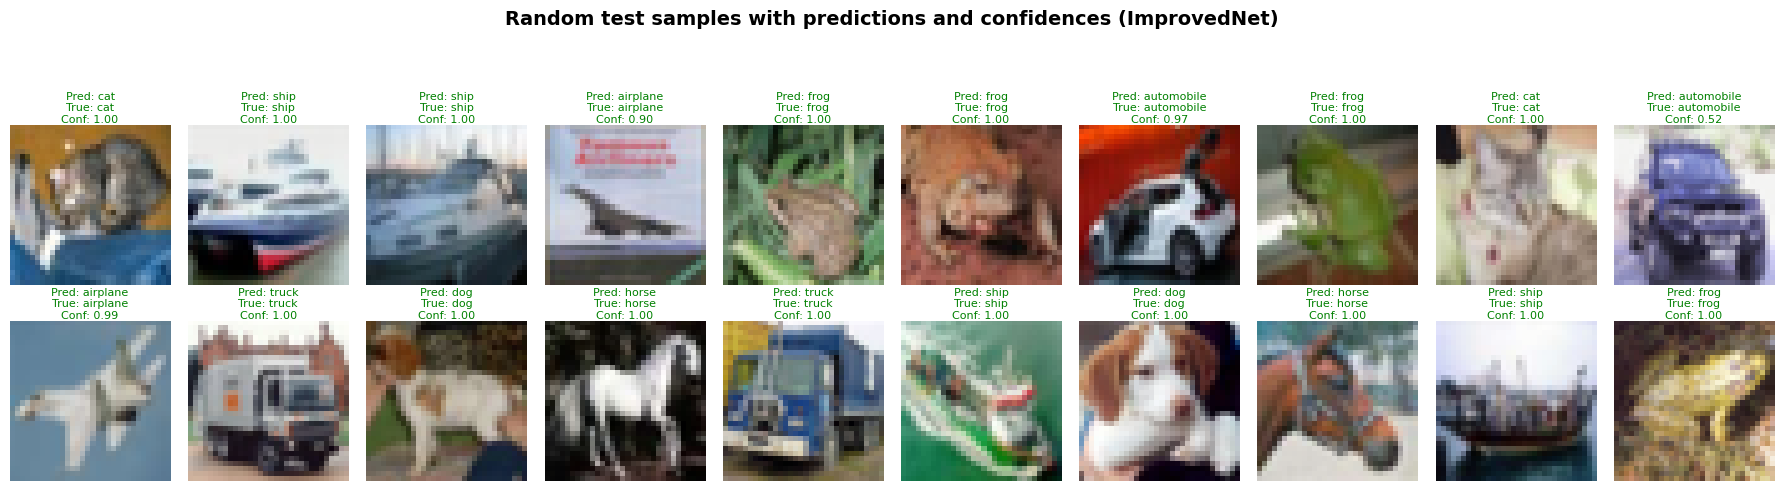

In [55]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# --------------------
# 可视化：随机 20 张测试图 + 预测 + 置信度（美化版）
# --------------------
model_for_vis = improved_model  # 或 baseline_model
model_for_vis.eval()

# 取一批测试图
dataiter = iter(test_loader)
images, labels = next(dataiter)

# 放到 GPU（如果有）
images_gpu = images.to(device)

with torch.no_grad():
    outputs = model_for_vis(images_gpu)
    probs = F.softmax(outputs, dim=1)  # [batch, 10]
    _, preds_tensor = torch.max(outputs, 1)

# 全放回 CPU，方便画图
probs_cpu = probs.cpu()
preds = preds_tensor.cpu().numpy()
images_cpu = images.cpu()

# 最多展示 20 张
n_show = min(20, images_cpu.size(0))
rows, cols = 2, 10

# ✅ 把高度从 4.5 调大到 5.5，整体更“高”一点
fig, axes = plt.subplots(rows, cols, figsize=(18, 5))
axes = np.array(axes).reshape(-1)
# 先关掉所有轴
for ax in axes:
    ax.axis("off")

for idx in range(n_show):
    ax = axes[idx]

    # 如果你现在用的是 newimshow(img, ax=...)，这里改成 newimshow
    # 假设 imshow(img, ax=None) 已经支持 ax 参数并且会反归一化
    newimshow(images_cpu[idx], ax=ax)

    pred_label = class_names[preds[idx]]
    true_label = class_names[labels[idx]]
    confidence = probs_cpu[idx, preds[idx]].item()

    correct = (preds[idx] == labels[idx].item())
    color = "green" if correct else "red"

    # 三行标题：Pred / True / Conf
    ax.set_title(
        f"Pred: {pred_label}\n"
        f"True: {true_label}\n"
        f"Conf: {confidence:.2f}",
        color=color,
        fontsize=8,
        pad=2
    )

    # 加一个有颜色的边框，进一步强调对/错
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(1.5)

# 整体大标题
fig.suptitle(
    "Random test samples with predictions and confidences (ImprovedNet)",
    fontsize=14,
    fontweight="bold",
    y=1.02
)

# 调整布局：留点空间给上面的 suptitle
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
